In [11]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
# setup disply parameters
import pandas as pd
import numpy as np
from matplotlib import pylab as plt
from matplotlib.ticker import StrMethodFormatter
float_formatter = StrMethodFormatter('{x:0.03f}')
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))
SMALL_SIZE = 14
MEDIUM_SIZE = 16
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rc('figure', figsize=(18, 6)) # set figure size

## Running a Negotiation

NegMAS has several built-in negotiation `Mechanism` s (`Protocol` s), negotiation agents (`Negotiator` s), and `UtilityFunction` s. You can use these to run negotiations as follows:

In [12]:
import random # for generating random ufuns
random.seed(0) # for reproducibility
from pprint import pprint # for printing
from negmas import SAOMechanism, AspirationNegotiator, MappingUtilityFunction

session = SAOMechanism(outcomes=10, n_steps=100)
negotiators = [AspirationNegotiator(name=f'a{_}') for _ in range(5)]
for negotiator in negotiators:
    session.add(negotiator, ufun=MappingUtilityFunction(lambda x: random.random() * x[0]))

pprint(session.run().__dict__)

{'agreement': (8,),
 'broken': False,
 'current_offer': (8,),
 'current_proposer': 'a2-5aac9b8c-26d4-4f65-87a9-80db194a2fb6',
 'error_details': '',
 'has_error': False,
 'n_acceptances': 0,
 'n_negotiators': 5,
 'new_offers': [],
 'relative_time': 0.15,
 'results': None,
 'running': False,
 'started': True,
 'step': 14,
 'time': 0.0038831250000015416,
 'timedout': False,
 'waiting': False}


Negotations end with a status that shows you what happens. In the above example, we can see that the negotiation was not broken and did not time-out. The agreement was on outcome `(4,)` of the *10* possible outcomes of this negotiation. That offer was offered by negotiator `a0` (the rest of the agent *ID* is always a random value to ensure no name repetitions) which was accepted by all of the other *4* negotiators.

It is possible to run the same negotiation using a `Protocol` object instead of a `Mechanism` object

In [13]:
random.seed(0) # for reproducibility
from negmas import SAOProtocol

session = SAOProtocol(outcomes=10, n_steps=100)
negotiators = [AspirationNegotiator(name=f'a{_}') for _ in range(5)]
for negotiator in negotiators:
    session.add(negotiator, ufun=MappingUtilityFunction(lambda x: random.random() * x[0]))

pprint(session.run().__dict__)

{'agreement': (8,),
 'broken': False,
 'current_offer': (8,),
 'current_proposer': 'a2-4c716440-5f33-4d20-bbe1-13c2c7bb1f17',
 'error_details': '',
 'has_error': False,
 'n_acceptances': 0,
 'n_negotiators': 5,
 'new_offers': [],
 'relative_time': 0.15,
 'results': None,
 'running': False,
 'started': True,
 'step': 14,
 'time': 0.0074510620000012295,
 'timedout': False,
 'waiting': False}


As you can see, we got the same output.`Protocol` is an alias of `Mechanism` in NegMAS.

Let's try a more meaningful situation:
Assume we have a buyer and a seller who are negotiating about a business transaction in which the buyer wants to maximize his profit while the seller wants to minimize her cost. They both would like to transact on as much as possible of the product and each has some preferred delivery time.

This can be modeled in the following negotiation:


In [14]:
from negmas import Issue, SAOMechanism, AspirationNegotiator, normalize
from negmas.utilities import LinearUtilityAggregationFunction as LUFun
issues = [Issue(name='price', values=10), Issue(name='quantity', values=10)
          , Issue(name='delivery_time', values=10)]
session = SAOMechanism(issues=issues, n_steps=20)

buyer_utility = normalize(ufun=LUFun(issue_utilities={'price': lambda x: 9.0 - x
                                       , 'quantity': lambda x: 0.2 * x
                                       , 'delivery_time': lambda x: x})
                         , outcomes=session.outcomes)

seller_utility = normalize(ufun=LUFun(issue_utilities={'price': lambda x: x
                                       , 'quantity': lambda x: 0.2 * x
                                       , 'delivery_time': lambda x: 9.0 - x})
                           , outcomes=session.outcomes)


session.add(AspirationNegotiator(name='buyer'), ufun=buyer_utility)
session.add(AspirationNegotiator(name='seller'), ufun=seller_utility)
pprint(session.run().__dict__)

{'agreement': {'delivery_time': 8, 'price': 9, 'quantity': 9},
 'broken': False,
 'current_offer': {'delivery_time': 8, 'price': 9, 'quantity': 9},
 'current_proposer': 'seller-ad4c617c-ff00-425f-91ea-1a5548dd15c2',
 'error_details': '',
 'has_error': False,
 'n_acceptances': 0,
 'n_negotiators': 2,
 'new_offers': [],
 'relative_time': 0.9,
 'results': None,
 'running': False,
 'started': True,
 'step': 17,
 'time': 0.003465158000000912,
 'timedout': False,
 'waiting': False}


In this run, we can see that the agreement was on a high price (*9*) which is preferred by the seller but with a delivery time of *8* which is preferred by the buyer. Negotiation took *17* steps out of the allowed *20* (*90%* of the available time)


We can check the negotiation history as well


In [15]:
for i, _ in enumerate(session.history):
    print(f'{i:03}: {_.new_offers}')

000: [('buyer-3c173a7a-5a49-420e-9d20-c9a6d0d5da7b', {'price': 0, 'quantity': 9, 'delivery_time': 9}), ('seller-ad4c617c-ff00-425f-91ea-1a5548dd15c2', {'price': 9, 'quantity': 9, 'delivery_time': 0})]
001: [('buyer-3c173a7a-5a49-420e-9d20-c9a6d0d5da7b', {'price': 0, 'quantity': 9, 'delivery_time': 9}), ('seller-ad4c617c-ff00-425f-91ea-1a5548dd15c2', {'price': 9, 'quantity': 9, 'delivery_time': 0})]
002: [('buyer-3c173a7a-5a49-420e-9d20-c9a6d0d5da7b', {'price': 0, 'quantity': 9, 'delivery_time': 9}), ('seller-ad4c617c-ff00-425f-91ea-1a5548dd15c2', {'price': 9, 'quantity': 9, 'delivery_time': 0})]
003: [('buyer-3c173a7a-5a49-420e-9d20-c9a6d0d5da7b', {'price': 0, 'quantity': 9, 'delivery_time': 9}), ('seller-ad4c617c-ff00-425f-91ea-1a5548dd15c2', {'price': 9, 'quantity': 9, 'delivery_time': 0})]
004: [('buyer-3c173a7a-5a49-420e-9d20-c9a6d0d5da7b', {'price': 0, 'quantity': 9, 'delivery_time': 9}), ('seller-ad4c617c-ff00-425f-91ea-1a5548dd15c2', {'price': 9, 'quantity': 9, 'delivery_time': 

We can even plot the complete negotiation history and visually see how far were the result from the pareto frontier (it was 0.0 utility units far from it). 

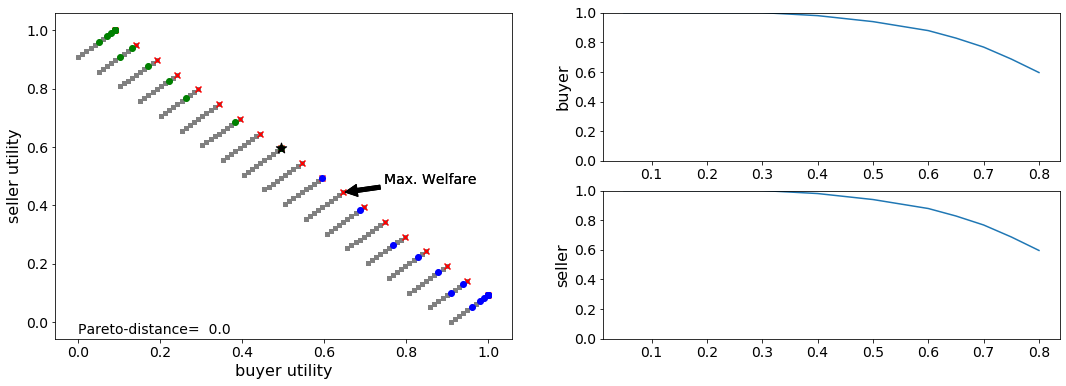

In [16]:
session.plot(plot_outcomes=False)

What happens if the seller was much more interested in delivery time. 

Firstly, what do you expect? 

Given that delivery time becomes a more important issue now, the seller will get more utility points by allowing the price to go down given that the delivery time can be made earlier. This means that we should expect the delivery time and price to go down. Let's see what happens:

In [17]:
session = SAOMechanism(issues=issues, n_steps=50)

seller_utility = normalize(ufun=LUFun(issue_utilities={'price': lambda x: x
                                       , 'quantity': lambda x: 0.2 * x
                                       , 'delivery_time': lambda x: 9.0 - x}
                                     , weights = {'price': 1.0, 'quantity': 1.0, 'delivery_time': 10.0})
                         , outcomes=session.outcomes)

session.add(AspirationNegotiator(name='buyer'), ufun=buyer_utility)
session.add(AspirationNegotiator(name='seller'), ufun=seller_utility)
pprint(session.run().__dict__)

{'agreement': {'delivery_time': 5, 'price': 5, 'quantity': 4},
 'broken': False,
 'current_offer': {'delivery_time': 5, 'price': 5, 'quantity': 4},
 'current_proposer': 'seller-173db5fe-e74c-4606-a852-20cab203b9a4',
 'error_details': '',
 'has_error': False,
 'n_acceptances': 0,
 'n_negotiators': 2,
 'new_offers': [],
 'relative_time': 0.9,
 'results': None,
 'running': False,
 'started': True,
 'step': 44,
 'time': 0.0098199189999999,
 'timedout': False,
 'waiting': False}


We can check it visually as well:

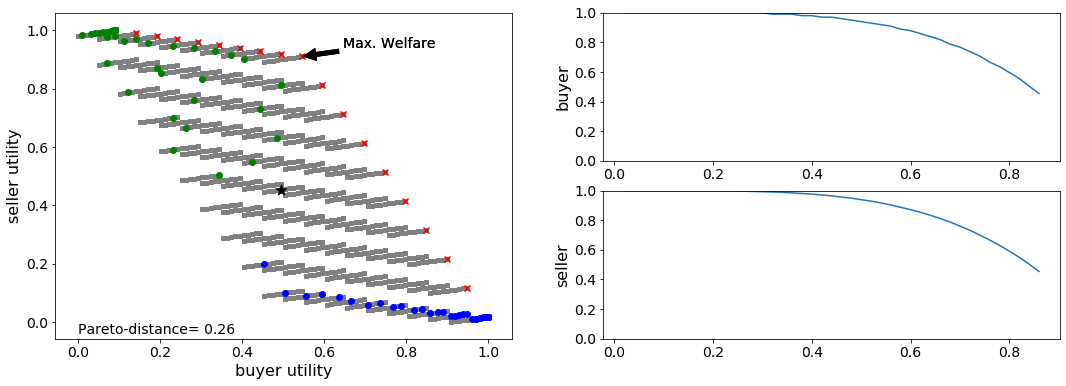

In [18]:
session.plot(plot_outcomes=False)

It is clear that the new ufuns transformed the problem. Now we have a single outcome at the pareto front. Nevertheless, there is money on the table as the negotiators did not agree on an outcome on the pareto front. 

What happens if we give them more time to negotiate:


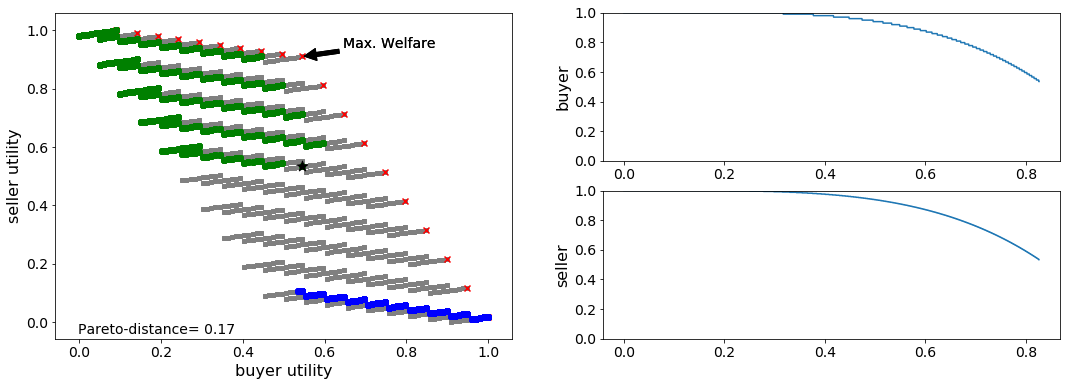

In [19]:
session = SAOMechanism(issues=issues, n_steps=5000)

seller_utility = normalize(ufun=LUFun(issue_utilities={'price': lambda x: x
                                       , 'quantity': lambda x: 0.2 * x
                                       , 'delivery_time': lambda x: 9.0 - x}
                                     , weights = {'price': 1.0, 'quantity': 1.0, 'delivery_time': 10.0})
                         , outcomes=session.outcomes)

session.add(AspirationNegotiator(name='buyer'), ufun=buyer_utility)
session.add(AspirationNegotiator(name='seller'), ufun=seller_utility)
session.run()
session.plot(plot_outcomes=False)

It did not help! The two agents adjusted their concession to match the new time and they did not get to the Pareto-front. 

Let's allow them to concede faster by setting their `aspiration_type` to *linear* instead of the default *boulware*:


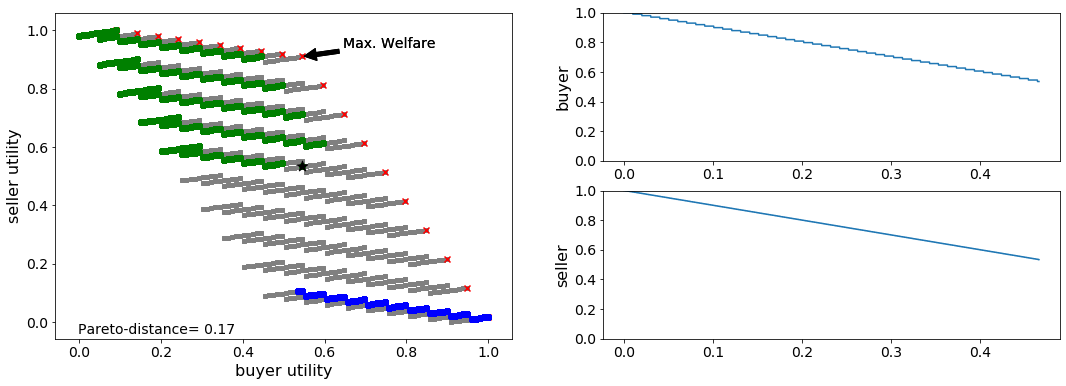

In [20]:
session = SAOMechanism(issues=issues, n_steps=5000)

seller_utility = normalize(ufun=LUFun(issue_utilities={'price': lambda x: x
                                       , 'quantity': lambda x: 0.2 * x
                                       , 'delivery_time': lambda x: 9.0 - x}
                                     , weights = {'price': 1.0, 'quantity': 1.0, 'delivery_time': 10.0})
                         , outcomes=session.outcomes)

session.add(AspirationNegotiator(name='buyer', aspiration_type="linear"), ufun=buyer_utility)
session.add(AspirationNegotiator(name='seller', aspiration_type="linear"), ufun=seller_utility)
session.run()
session.plot(plot_outcomes=False)

It is clear that longer negotiation time, and faster concession did not help the negotiators get to a point on the pareto-front. 